In [1]:
import pandas as pd
import torch
import seaborn as sns
import matplotlib.pylab as plt

from monteloanco import Model

# Read model

In [2]:
model = Model(embedding_size=4, input_size=100_000, device='cpu')
model.load_state_dict(torch.load('monteloanco.pt', weights_only=True))

<All keys matched successfully>

# Read data

In [3]:
df_jsonl = pd.read_json('accepted_2007_to_2018Q4.jsonl.gz', lines=True).set_index('id')

In [4]:
df = pd.read_csv('monteloanco.csv.gz', index_col='id')
df = df.join(df_jsonl, how='inner').reset_index()

In [5]:
df.installment = df.installment.apply(torch.tensor)
df.pymnt = df.pymnt.apply(torch.tensor)

# Perform test simulation

In [6]:
row = df.sample(1).squeeze()
print(row)
hidden_states, sim_pymnts = model.forward(
    batchidx=0,
    idx=torch.tensor(row.name).repeat(100), 
    installments=row.installment.unsqueeze(0).repeat(100, 1))

id                                                       46235095
0                                                       -0.914916
1                                                       -5.736644
2                                                        5.565982
3                                                       -2.881602
pd                                                       0.000009
issue_d                                             1427846400000
term_numeric                                                   36
installment     [tensor(303.9100), tensor(303.9100), tensor(30...
pymnt           [tensor(303.4987), tensor(303.4987), tensor(30...
Name: 16343, dtype: object


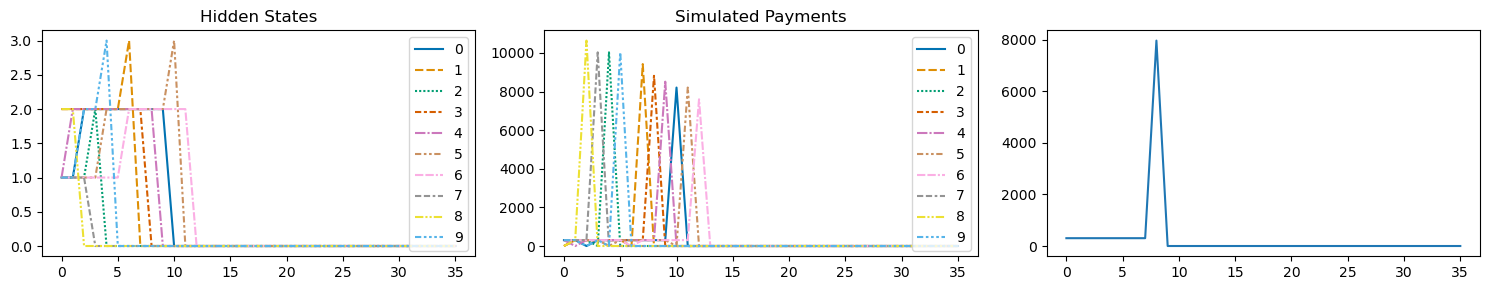

In [7]:
fig, ax = plt.subplots(1, 3, figsize=(15, 3))
sns.lineplot(hidden_states.detach().numpy()[:,:10], ax=ax[0], palette='colorblind')
sns.lineplot(sim_pymnts.detach().numpy()[:,:10], ax=ax[1], palette='colorblind')
sns.lineplot(row.pymnt, ax=ax[2])
ax[0].set_title(f"Hidden States")
ax[1].set_title(f"Simulated Payments")
plt.tight_layout()
plt.show()

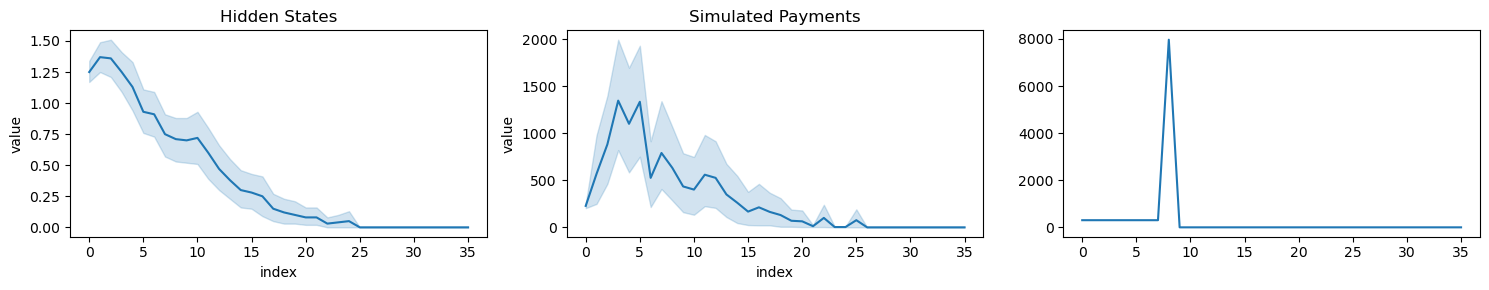

In [8]:
fig, ax = plt.subplots(1, 3, figsize=(15, 3))
sns.lineplot(pd.DataFrame(hidden_states.detach().numpy()).reset_index().melt(id_vars='index'), x='index', y='value', errorbar=('ci', 95), ax=ax[0])
sns.lineplot(pd.DataFrame(sim_pymnts.detach().numpy()).reset_index().melt(id_vars='index'), x='index', y='value', errorbar=('ci', 95), ax=ax[1])
sns.lineplot(row.pymnt, ax=ax[2])
ax[0].set_title(f"Hidden States")
ax[1].set_title(f"Simulated Payments")
plt.tight_layout()
plt.show()

# Simulate full dataset

In [9]:
from torch.utils.data import BatchSampler
from collections import defaultdict


# Custom BatchSampler
class GroupedBatchSampler(BatchSampler):
    def __init__(self, dataset, batch_size, grouper='pymnt'):

        # Group indices by tensor length
        self.length_to_indices = defaultdict(list)
        for idx in range(len(dataset)):
            tensor_length = len(dataset[idx][grouper])
            self.length_to_indices[tensor_length].append(idx)

        # Create batches within each group
        self.batches = []
        for length, indices in self.length_to_indices.items():
            for i in range(0, len(indices), batch_size):
                self.batches.append(indices[i:i + batch_size])

    def __iter__(self):
        return iter(self.batches)

    def __len__(self):
        return len(self.batches)

# Create custom BatchSampler
batch_size = 100_000
dataset = df[['id', 'installment', 'pymnt']].reset_index(names='idx').to_dict(orient='records')
grouped_batch_sampler = GroupedBatchSampler(dataset, batch_size)

In [10]:
from torch.utils.data import DataLoader

In [11]:
batches = [] 
for batchidx, batch in enumerate(DataLoader(dataset, batch_sampler=grouped_batch_sampler, num_workers=1)):
    batches.append(model.forward(batchidx, batch['idx'], batch['installment']))
hidden_states, sim_pymnts = zip(*batches)
#hidden_states = torch.concat(hidden_states, axis=-1)
#sim_pymnts = torch.concat(sim_pymnts, axis=-1)

In [12]:
from itertools import chain

s_sim_pymnts = pd.Series(torch.concat([x.sum(axis=0) for x in sim_pymnts]), index=chain.from_iterable(grouped_batch_sampler.batches))
s_sim_pymnts

0         8368.500977
1        10379.250000
2        24643.794922
5         7547.398926
6        10997.000000
             ...     
97787    21834.359375
98136    33183.535156
98750    46961.640625
98783    22073.039062
99858    32685.630859
Length: 100000, dtype: float32

In [13]:
s_sim_pymnts.sum()

1222503700.0

# Score distributions

In [14]:
tmat = model._idx_to_tmat(
    torch.arange(dataset.__len__()), 
    batch_size=dataset.__len__())

In [15]:
def tmat_to_score(tmat):
    '''
    Function to identify probability of account being up to date after 12 months
    '''
    score = torch.zeros(8)
    score[1] = 1.
    for _ in range(12): score = torch.matmul(score, tmat)
    return score

scores = torch.vmap(tmat_to_score)(tmat)[(torch.arange(len(tmat)), 7)]

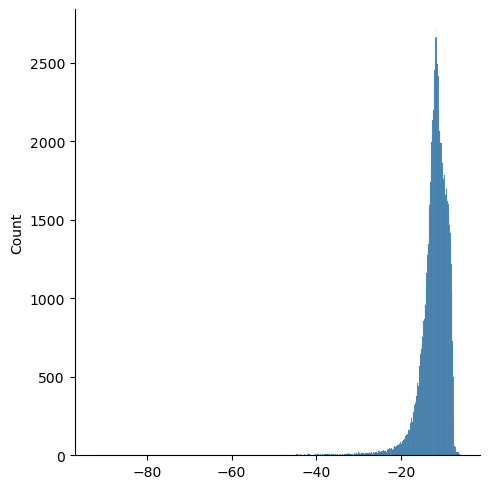

In [16]:
from scipy.special import logit

sns.displot(logit(scores.detach().numpy()), kind='hist')

In [17]:
df['pymnt_sum'] = [x.sum().item() for x in df.pymnt]
df['installment_sum'] = [x.sum().item() for x in df.installment]
df = df.join(s_sim_pymnts.rename('sim_pymnts_sum'))

In [18]:
df['pd_qcut'] = pd.qcut(df.pd, q=11)
df.groupby('pd_qcut', observed=False)[['pymnt_sum', 'installment_sum', 'sim_pymnts_sum']].sum()

,pymnt_sum,installment_sum,sim_pymnts_sum
pd_qcut,,,
"(-0.001, 1.46e-07]",1.031322e+08,1.007965e+08,100702904.0
"(1.46e-07, 8.2e-07]",1.121598e+08,1.130873e+08,112713992.0
"(8.2e-07, 2.13e-06]",1.103009e+08,1.112607e+08,110465032.0
"(2.13e-06, 4.18e-06]",1.086365e+08,1.108801e+08,109510600.0
"(4.18e-06, 7.23e-06]",1.079404e+08,1.110812e+08,109202368.0
"(7.23e-06, 1.18e-05]",1.074036e+08,1.103351e+08,108095168.0
"(1.18e-05, 2.09e-05]",1.042847e+08,1.087573e+08,106443208.0
"(2.09e-05, 4.07e-05]",1.041338e+08,1.102560e+08,107885744.0
"(4.07e-05, 8.56e-05]",1.051941e+08,1.121953e+08,109782592.0
